### Project Group 1 in Practical Planning Robust Behavior for autonomous driving
# Reinforcement Learning using Graph Neural Networks

### Tom Dörr, Marco Oliva, Quoc Trung Nguyen, Silvan Wimmer

__Objective__: Exploit the graph-like structure of tragic scenarios by applying graph neural networks to the Soft-Actor-Critic algorithm.
## Chapter 1: Basic Setup
### 1.1: Imports

In [18]:
from bark.runtime.commons.parameters import ParameterServer
from bark_ml.environments.blueprints import ContinuousHighwayBlueprint
from bark_ml.environments.single_agent_runtime import SingleAgentRuntime
from bark_ml.library_wrappers.lib_tf_agents.agents import BehaviorGraphSACAgent
from bark_ml.observers.graph_observer import GraphObserver
import tensorflow as tf
import numpy as np

## Chapter 3: Graph Neural Networks

Before diving into how we apply graph neural networks to our problem, let's have a **very brief** overview about the idea behind them.  
Most importantly, they operate on graph structured data, i.e. data consisting of 
- **Nodes:** feature vectors (node embeddings) of some data entities (and optionally a label), in our case each vehicle is a node
- **Edges:** specified links between nodes
- **Edge features:** optionally, each link between nodes can have its own feature vector

In the section about the `GraphObserver` above, we've already seen how this graph can look like in our scenario. Let's take a step back and use a simplified visualization where the green node represents the ego vehicle and the remaining nodes are other vehicles in its vicinity on the road.

![Schematic view of a GNN](images/simple_gnn.png)

The ego node is connected to both other nodes (it "sees" the other nodes) which in turn do not see each other.

Now, the nodes send messages (their current embeddings) along all outgoing links (here, all links are bidrectional), propagated through a neural network. From now on, we refer to this neural network as the _message passing layer(s)_.

> **NOTE**  
All edges share the same neural network, instead of each edge having its own weights.

Each node aggregates all incoming messages using an aggregation function, like summing or averaging. The result is then processed by another neural network, e.g. a recurrent unit, which computes the new embedding of the node.


In our project, we have integrated two different libraries that offer GNN implementations:
1. [tf2_gnn](https://github.com/microsoft/tf2-gnn): the library that was initially planned to be used in the project
2. [Spektral](https://graphneural.network/#installation): a library that supports edge features, which `tf2_gnn` does not

In summary, the node embeddings are updated as follows (exemplary):

```python
embeddings = recurrent_unit(embeddings, sum(edge_mlp(neighbor_embeddings)))
```
or

$$h_{i,t} = \mathrm{g} \big(h_{i, t-1}, \sum^{N_{i, t}}_j \mathrm{f}(n_{j,t-1}) \big)$$ where $h_{i,t}$ is the embedding of node $i$ at time $t$, $\mathrm{g}$ may be a gated recurrent unit at the nodes, $N_{i, t}$ is the number of neighbors (incoming edges) of node $i$ at time $t$, $n_j$ are the neighbors and $\mathrm{f}$ is a simple feed-forward neural network on the edges.

## Chapter 4: The `GNNWrapper` class

As an abstraction over the specific implementation of the graph neural network, we implemented a wrapper class called `GNNWrapper`. Its primary function is to act just as a GNN and so the only interface is the `call` function that accepts a batch of observations (array representations of graphs) and returns a batch of updated node embeddings for each graph.

In order to support `tf2_gnn` and `Spektral`, we have two distinct call implementations, one for each library. The `GNNWrapper` class decides which one to call based on the arguments given in the initialization.

Both functions however work almost the same:
1. Convert the given observations into nodes, edges and, when using `Spektral`, edges features.
2. Call the respective library with the converted graph representation.

When specifying `Spektral` as the GNN library, the call function looks like this:

In [14]:
from spektral.layers import EdgeConditionedConv, GlobalAttnSumPool
from tensorflow.keras.layers import Dense
from bark_ml.observers.graph_observer import GraphObserver
from docs.report.helper_functions import get_sample_observations, graph_dims

def call_spektral_demo(observations):
    # define the layers of the GNN (normally, this happens upon initialization)
    
    # this defines an edge-conditioned convolution as the message passing layer
    # the `kernel_network` argument defines the layers of the edge neural network
    edge_convolution = EdgeConditionedConv(channels=16, kernel_network=[128], activation="relu")
    
    # after message passing, we'll to pass the node embeddings though a dense layer
    dense = Dense(units=256, activation="relu")

    def call_spektral(observations, training=False):
        # convert the observations into
        # old_embeddings: tensor containing the node features (embeddings)
        # A: binary adjacency matrix specifying edges in the graph
        # E: tensor containg edge features
        old_embeddings, A, E = GraphObserver.graph(observations, graph_dims)

        # pass the inputs through an edge conditioned convolution
        # layer and receive new node embeddings
        new_embeddings = edge_convolution([old_embeddings, A, E])
        
        # pass the new node embeddings through a dense layer
        X = dense(new_embeddings)

        # output the final transformed node embeddings
        return old_embeddings, new_embeddings
    
    old_embeddings, new_embeddings = call_spektral(observations)
    
    print("Here's how the embeddings of the ego agent have changed:\n")
    print(f'old embeddings of shape {old_embeddings[0, 0].shape}: \n{old_embeddings[0,0,:].numpy()}\n')
    print(f'new embeddings of shape {new_embeddings[0, 0].shape}: \n{new_embeddings[0,0,:].numpy()}')

# uncomment the following line to call the function with sample observations
call_spektral_demo(get_sample_observations())

Here's how the embeddings of the ego agent have changed:

old embeddings of shape (5,): 
[0.02944617 0.531453   0.9274401  0.39086574 0.07298207]

new embeddings of shape (16,): 
[0.42647105 0.30279604 0.         0.29276448 0.2175161  0.09178288
 0.         0.39766562 0.         0.         0.42999676 0.15180485
 0.02260317 0.         0.68303376 0.45430782]


In comparison, when `tf2_gnn` is specified, the implementation looks like this:

In [15]:
from tf2_gnn.layers import GNN, GNNInput
import pprint as pp
import tensorflow as tf

def call_tf2_gnn_demo(observations):
    # the number and types of layers in the GNN are all encoded
    # in the parameters dictionary, let's stick to the default for now
    gnn_params = GNN.get_default_hyperparameters()

    # uncomment the following two lines to have a look at them
    print(f'GNN parameters:')
    pp.pprint(gnn_params)

    # initialize a GNN instance which acts as a keras layer
    gnn = GNN(gnn_params)

    def call_tf2_gnn(observations, training=False):
        batch_size = tf.constant(observations.shape[0])

        # convert the observations into
        # old_embeddings: tensor containing the node features
        # A: dense adjacency list in the format [[0, 1], [2, 4]]
        #    specifying source and target node ids of an egde
        # node_to_graph_map: a tensor that assigns each node in X to a graph
        old_embeddings, A, node_to_graph_map = GraphObserver.graph(
          observations,
          graph_dims=graph_dims, 
          dense=True)
        
        # build the struct that tf2_gnn expects as input
        gnn_input = GNNInput(
          node_features=old_embeddings,
          adjacency_lists=(A,),
          node_to_graph_map=node_to_graph_map,
          num_graphs=batch_size,
        )

        new_embeddings = gnn(gnn_input, training=training)
        
        # only for demo purposes
        old_embeddings = tf.reshape(old_embeddings, [batch_size, graph_dims[0], -1])
        new_embeddings = tf.reshape(new_embeddings, [batch_size, 5, -1])
        
        return old_embeddings, new_embeddings
    
    old_embeddings, new_embeddings = call_tf2_gnn(observations)
    
    print("\nHere's how the embeddings of the ego agent have changed:\n")
    print(f'old embeddings of shape {old_embeddings[0, 0].shape}: \n{old_embeddings[0,0,:].numpy()}\n')
    print(f'new embeddings of shape {new_embeddings[0, 0].shape}: \n{new_embeddings[0,0,:].numpy()}')

# uncomment the following line to call the function with sample observations
#call_tf2_gnn_demo(get_sample_observations())

Having the GNN functionality nicely abstracted behind this wrapper, we can now easily integrate it into the Soft-Actor-Critic framework.

## Chapter 5: The Soft-Actor-Critic Algorithm with Graph Neural Networks

Next, let's examine the integrated system.

We want to exploit the graph-like structure of traffic scenarios and have already encoded the state of the world as a graph. Now, we want to apply graph neural networks to the SAC algorithm. 

The resulting actor and critic networks are quite similar in structure. Here's how they work and what they compute.

### The Actor Network

Implemented in the class `GNNActorNetwork`.


**Input**: a batch of observations of shape _(batch_size, observation_size)_  
**Output**: a batch of a normal distributions over the action space from which the policy will sample the actions performed by the agent

![Actor Network Architecture](images/actor_architecture.png)

**1. GNN**  
The observations are directly fed into the graph neural network (a `GNNWrapper` instance). It converts the observations into graphs and computes new node embeddings for each graph by means of message passing and aggregation. Optionally, the new note embeddings are propagated through a dense layer before being returned.

> **NOTE**  
From here on, we're only interested in the embeddings of the ego agent. Hence, instead of feeding the whole graph representation into the encoding network, we extract the embeddings of the first node of each graph, which represents the ego agent.

**2. Encoding Network**  
In the encoding network, the node embeddings of the ego agent are now passed through a series of dense layers. Depending on the parameters passed into the actor, we can also add convolutions, dropout and other types of layers here.

**3. Projection Network**  
Finally, the projection network receives the hidden representations after the encoding network and computes a normal distribution over the action space for each observation contained in the batch, modeled by a mean and a standard deviation.

In a very simplified manner for brevity, the implementation of the actor's `call` function looks as follows:
```python
def call(self, observations, training=False):
    # get the updated node embeddings
    output = self._gnn(observations, training=training)

    # extract the ego state (the first node embedding vector of each batch element)
    output = output[:, 0]
    
    # pass the ego agent's node embeddings through the encoder
    output = self._encoder(output, training=training)
    
    # compute a normal distribution
    output = self._projection_net(output, training=training)

    return output
```

### The Critic Network

Implemented in the class `GNNCriticNetwork`.

**Input**: a batch of observation-action pairs, i.e. `[obs, action]` with shapes _(batch_size, observation_size)_ and _(batch_size, 2)_  
**Output**: a scalar value assigned to each observation-action pair


The major difference compared to the actor network is that in the critic, we have two parallel pipelines for the observations and their corresponding actions.

![Critic Network Architecture](images/critic_architecture.png)

**1. Actions**  
The actions are simply passed into an action encoding network that works similar to the encoding network of the actor network, i.e. a series of dense layers with optional convolutions, dropout layers, etc.

**2. Observations**  
The observations are processed in the exact same way as in the actor network. We compute new graph representations in the GNN, extract the ego node embeddings and pass them through an encoding network.

**3. Joining Actions and Observations**  
After receiving the outputs from the action and observation encoding networks, we concatenate the observation-action pair of each element in the batch to one feature vector.  
Finally, we pass this concatenated state through a fully connected joint network which outputs a scalar value for each observation-action pair.

Again, a simplified version of the implemenation looks like this:
```python
def call(self, inputs, training=False):
    observations, actions = inputs
     
    # get the updated node embeddings
    node_embeddings = self._gnn(observations, training=training)
    
    # extract the ego state (the first node embedding vector of each batch element)
    output = output[:, 0]
    
    # pass the node embeddings through their observation encoder
    node_embeddings = self._observation_encoder(node_embeddings, trainig=training)
    
    # do the same for the actions with a different action encoder
    actions = self._action_encoder(actions, training=training)
    
    # concatenate observations and actions into one vector
    joint = tf.concat([node_embeddings, actions], 1)
    
    # compute a scalar output value
    output = self._joint_net(joint, training=training)

    return output, network_state
```

### Putting it all together

The following cell sets up an SAC-agent using the graph neural networks described above to be used in BARK-ML.

Initializing CriticNetwork_GNN with 'spektral'...
Initializing ActorNetwork_GNN with 'spektral'...
[256, 128]
Initializing TargetCriticNetwork1_GNN with 'spektral'...
Initializing CriticNetwork2_GNN with 'spektral'...


INFO:absl:No checkpoint available at 


Initializing TargetCriticNetwork2_GNN with 'spektral'...

Network                        Parameters
ActorNetwork...................... 298.820
CriticNetwork..................... 265.921
CriticNetwork2.................... 265.921
TargetCriticNetwork1.............. 265.921
TargetCriticNetwork2.............. 265.921
------------------------------------------
Total parameters                 1.362.504


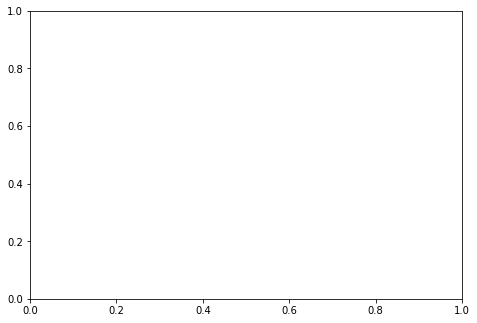

In [16]:
from docs.report.helper_functions import prepare_agent, summarize_agent

def init_agent():
    # set up parameters
    params = ParameterServer(filename='data/tfa_params.json')
    params['World']['remove_agents_out_of_map'] = False
    params['ML']['BehaviorGraphSACAgent']['ActorFcLayerParams'] = [256, 128]
    params['ML']['BehaviorGraphSACAgent']['GNN']['library'] = 'spektral'
    params['ML']['BehaviorGraphSACAgent']['GNN']['GraphDimensions'] = [4, 11, 4]
    
    # create environment
    bp = ContinuousHighwayBlueprint(params, number_of_senarios=2500, random_seed=0)
    observer = GraphObserver(params=params)
    env = SingleAgentRuntime(blueprint=bp, observer=observer, render=False)
    
    # create agent
    agent = BehaviorGraphSACAgent(environment=env, params=params)
    prepare_agent(agent, params, env)
    
    return agent

agent = init_agent()
summarize_agent(agent)

In case you feel like experimenting with the agent, execute the following cell to get an overview of the most important parameters you can tweak.

In [17]:
from docs.report.helper_functions import print_parameter_overview
print_parameter_overview()

Path: ["ML"]["GraphObserver"]["AgentLimit"] (int)
Description: Specifies the maximum number of agents that are included in an observation.
Default value: 4

Path: ['ML']['BehaviorGraphSACAgent']['CriticJointFcLayerParams']
Description: specifies the fully connected layers (number and sizes) of the critic joint network ([int])
Default value: [256, 128]

Path: ['ML']['BehaviorGraphSACAgent']['ActorFcLayerParams']
Description: specifies the fully connected layers (number and sizes) of the actor encoding network ([int])
Default value: [256, 128]

Path: ['ML']['BehaviorGraphSACAgent']['GNN']['NumMpLayers']
Description: specifies the number of message passing layers in the GNN (int)
Default value: 2

Path: ['ML']['BehaviorGraphSACAgent']['GNN']['MpLayerNumUnits']
Description: the number of units in the message passing layers in the GNN (int)
Default value: 128

Path: ['ML']['BehaviorGraphSACAgent']['GNN']['library']
Description: which library to use as the GNN implementation, either "tf2_gnn

## Chapter 6: Result and Evaluation
- introduce supervised setting
- benchmark GNN-SAC vs SAC, randomActor and ConstantActor

In [10]:
#to do 

## Chapter 7: Summary

## Apendix: Commands 

In [ ]:
os.getcwd()

# Run bazel commands from here (no visualizations)

In [ ]:
!pwd

!cd /home/silvan/working_bark && bazel run //examples:tfa

In [ ]:
!cd /home/silvan/working_bark && bazel run //examples:tfa